## Image Generation with Autoencoders, Variational Autoencoders, and GANs**


### **Abstract**

In this assignment, I used TMNIST dataset for training, tried and implemented several different architectures AE,VAE and GAN. According to the generated results, I made some conclusion and comparision.

References:

[TMNIST Alphabet](https://www.kaggle.com/nikbearbrown/tmnist-alphabet-94-characters)

[Kaggle](https://www.kaggle.com/monilkataria/mnist-ae-vae)



### **Questions:**

**1. Autoencoders (30 Points) Create at least 40 fake images using an AE architecture. How well did it do?  Adjust the size of the latent space. Change the network architecture. What combination of network architecture and latent space size gives the best trade-off between compression and quality?**

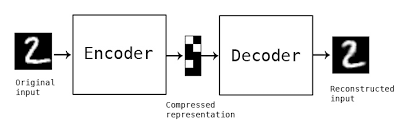

In [1]:
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import *
from keras import backend as K

In [2]:
# tmnist data
df_train = pd.read_csv('94_character_TMNIST.csv')
X = df_train.iloc[:, 2:786]
print(X.shape)

(274093, 784)


In [3]:
train_pct_index = int(0.8 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
X_train = X_train.values.astype('float32')/255.
X_test = X_test.values.astype('float32')/255.
output_X_train = X_train.reshape(-1,28,28,1)
output_X_test = X_test.reshape(-1,28,28,1)

print(X_train.shape, X_test.shape)

(219274, 784) (54819, 784)


In [4]:
#encoder
encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(32, activation = 'relu')(flat)

In [5]:
#AE decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)

m = 256
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
857/857 [==============================] - 96s 111ms/step - loss: 0.2106
Epoch 2/10
857/857 [==============================] - 102s 119ms/step - loss: 0.1782
Epoch 3/10
857/857 [==============================] - 94s 110ms/step - loss: 0.1466
Epoch 4/10
857/857 [==============================] - 94s 110ms/step - loss: 0.1379
Epoch 5/10
857/857 [==============================] - 94s 109ms/step - loss: 0.1294
Epoch 6/10
857/857 [==============================] - 96s 112ms/step - loss: 0.1441
Epoch 7/10
857/857 [==============================] - 95s 111ms/step - loss: 0.1396
Epoch 8/10
857/857 [==============================] - 93s 108ms/step - loss: 0.1468
Epoch 9/10
857/857 [==============================] - 95s 111ms/step - loss: 0.1485
Epoch 10/10
857/857 [==============================] - 99s 115ms/step - loss: 0.1359


In [6]:
test_imgs = autoencoder.predict(output_X_test)
print(test_imgs.shape)

(54819, 28, 28, 1)


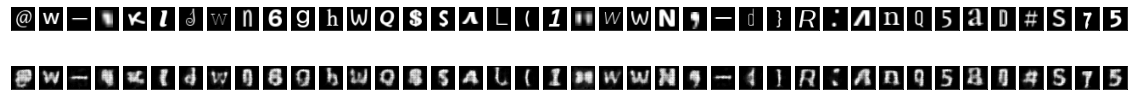

In [7]:
import matplotlib.pyplot as plt

n = 40  # how many digits we will display
plt.figure(figsize=(20, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

After the training of 10 Epochs, we can simply see the performance of AE. Although some details are still missing, the general shape can be generated, and the feature points are basically there.

An autoencoder is made of two components, here’s a quick reminder. The encoder brings the data from a high dimensional input to a bottleneck layer, where the number of neurons is the smallest. Then, the decoder takes this encoded input and converts it back to the original input shape — in our case an image. The latent space is the space in which the data lies in the bottleneck layer.

The latent space contains a compressed representation of the image, which is the only information the decoder is allowed to use to try to reconstruct the input as faithfullyas possible. To perform well, the network has to learn to extract the most relevant features in the bottleneck.

I tried different architectures, through add pooling and sampling, the generated result will be more clear but train with longer time.

**2. Variational Autoencoders (30 Points) Create at least 40 fake images using a VAE architecture. How well did it do?  Adjust the size of the latent space. Change the network architecture. What combination of network architecture and latent space size gives the best trade-off between compression and quality?**

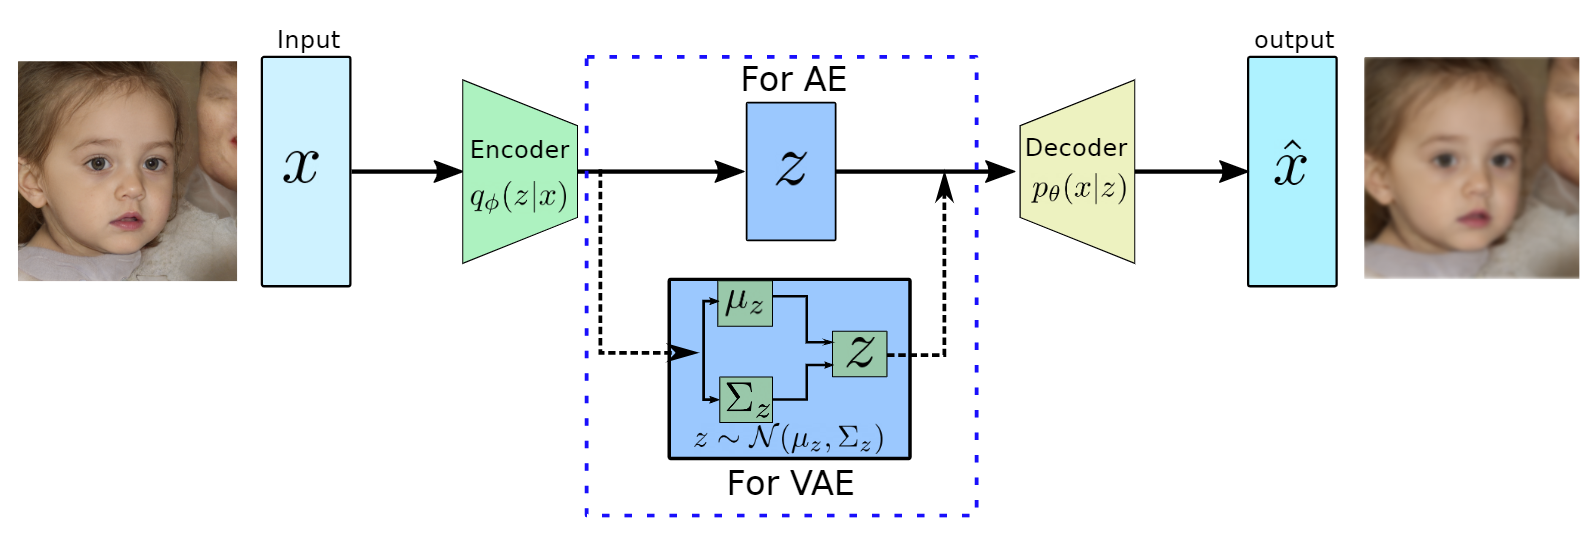

In [27]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )

In [29]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var


In [31]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_9[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_9[0][0]']                
                                                                                            

In [32]:
# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [33]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 512)               1536      
                                                                 
 dense_11 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [34]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [36]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [37]:
vae.fit(x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 51.8607 - val_loss: 44.0782
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 43.3174 - val_loss: 42.5067
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 42.3665 - val_loss: 41.8973
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 41.7170 - val_loss: 41.2556
Epoch 5/10
469/469 [==============================] - 4s 10ms/step - loss: 41.1969 - val_loss: 40.8002
Epoch 6/10
469/469 [==============================] - 4s 10ms/step - loss: 40.7891 - val_loss: 40.4568
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 40.4343 - val_loss: 40.2922
Epoch 8/10
469/469 [==============================] - 4s 10ms/step - loss: 40.1655 - val_loss: 39.9130
Epoch 9/10
469/469 [==============================] - 5s 10ms/step - loss: 39.8853 - val_loss: 39.7347
Epoch 10/10
469/469 [==============================] - 5s 10ms/step - loss:

In [38]:
test_imgs = vae.predict(x_test)
print(test_imgs.shape)

(10000, 784)


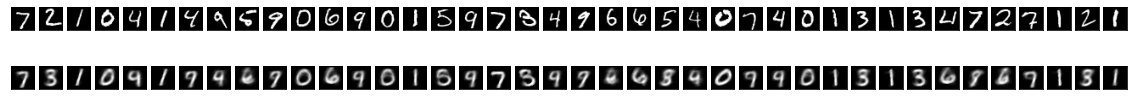

In [39]:
import matplotlib.pyplot as plt

n = 40  # how many digits we will display
plt.figure(figsize=(20, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Variational autoencoders (VAE) solve the problem of non-regularized potential Spaces in autoencoders and provide generative capability for the whole space. Encoder output potential vector in AE. The encoder for VAE does not output the vectors in the subspace, but the predefined distributed parameters in the subspace of each input. Then VAE imposes constraints on this potential distribution forcing it to become a normal distribution. This constraint ensures that the potential space is regularized.

After the same 10 epochs, VAE's overall performance was not good enough. But conceptually, its training limit should be more refined than AE.

VAE force the conditions of potential variables into the unit norm. The compressed form is the mean and variance of the potential variables. The underlying variables are smooth and continuous. Random values of potential variables produce meaningful output in the decoder. The input to the decoder is a random value sampled from a Gaussian with the mean and variance of the encoder's output.

**3. Generative Adversarial Networks (30 Points) Create at least 40 fake images using a GAN architecture. How well did it do?  Adjust the size of the level of input noise. Change the network architecture. What combination of network architecture and noise generates the best fake images?**


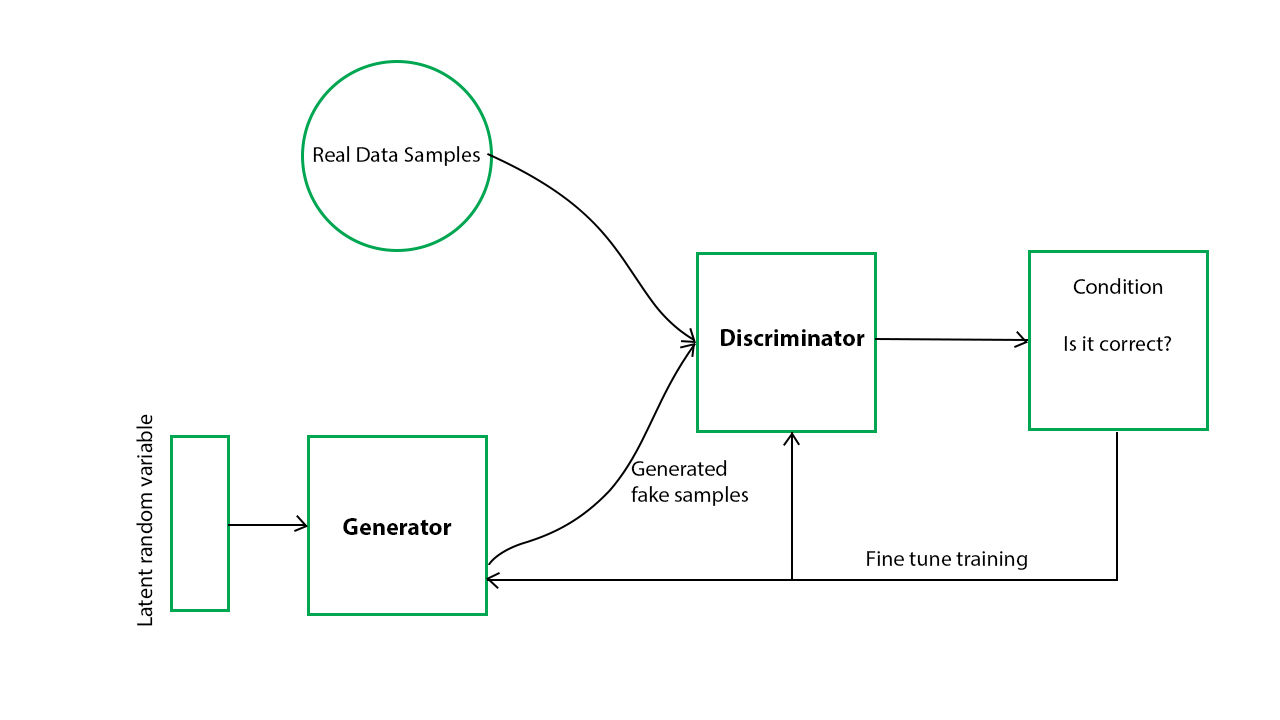

In [ ]:
from glob import glob
from PIL import Image
from IPython import display
import tensorflow.keras as kr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import pandas as pd

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 1000

**Utility Functions**

In [ ]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
            
        image = imageio.imread(filename)
        writer.append_data(image)

    # this is a hack to display the gif inside the notebook
    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [ ]:
def sample_images(generator, epoch, save=True, name='mnist'):
    """ Sample images from generator, plot them and save as png"""

    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            c += 1
            
    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

In [ ]:
X = pd.read_csv('94_character_TMNIST.csv')
X = X.iloc[:, 2:786]

X = X.values.astype('float32').reshape(X.shape[0], 28, 28, 1)
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

### The Generator Model

The generator will try to create images that are good enough to fool the discriminator. First, we are going to start with a simple model - with Dense layers -.

In [ ]:
def build_generator(output_shape=(28, 28, 1)): 
    model = kr.Sequential(name='generator')
    
    model.add(kr.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(1024))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(kr.layers.Reshape(output_shape))

    return model


generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                         

### The Discriminator model

The discriminator will try to distinguish fake images from real images. 

In [ ]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = kr.Sequential(name='discriminator')

    model.add(kr.layers.Flatten(input_shape=input_shape))
    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(256))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-t

In [ ]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,)) 
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         1493520   
                                                                 
 discriminator (Sequential)  (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [ ]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    
    # Shuffle and batch data 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 
    
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)
    d_loss, d_acc = 0.5 * np.add(loss_real, loss_fake)
    
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)
    display.clear_output(wait=True)
    print ("Epoch : %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_acc, g_loss))

Epoch : 9999 [D loss: 0.636452, acc.: 64.45%] [G loss: 1.011015]


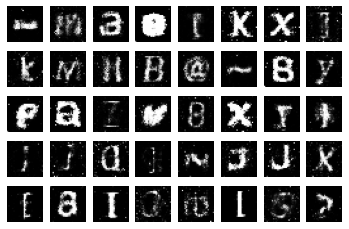

In [ ]:
sample_images(generator, None, save=False)

I would like to mention that training GAN is really hard as they are so sensetive to hyperparameters. Sometimes it is possible that the generation loss will became 0 and discriminator loss will keep increasing. After the same training of 10,000 epochs, GAN is still not fine enough. 

>MIT License
>
>Copyright (c) 2022 Divyanshu Bhardwaj
>
>Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
>
>The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
>
>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.